In [48]:
import os
import sys
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import osgeo.gdal
import urllib.request
import zipfile
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aqiGDL
%matplotlib inline

In [47]:
gob_building = gpd.sjoin(gdf_building, denue, how='inner', op='intersects')

In [46]:
save_path = os.path.join('../data/external/', 'denue')
urllib.request.urlretrieve(
            'https://www.inegi.org.mx/contenidos/masiva/denue/2019_11/denue_14_1119_shp.zip', save_path)

('../data/external/denue', <http.client.HTTPMessage at 0x7f9df1f7fd60>)

In [82]:

# define the name of the directory to be created
outputDirectory = '../data/external/denue_2019/'

try:
    os.makedirs(outputDirectory)
except IOError:
    print('cannot create', outputDirectory)
    
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    
    zip_ref.extractall(outputDirectory)

In [110]:
plt.style.use('dark_background')
colors = ['7A76C2', 'ff6e9c98', 'f62196', '18c0c4', 'f3907e', '66E9EC']
consumed = 144.06 #Per roof median emission kWh/m²/yr https://insights.sustainability.google/places/ChIJOwV0Q_qxKIQR7NCkjDwfR-k/buildings
emission = 0.00041423 #total carbon intensity tCO2e/kWh https://insights.sustainability.google/places/ChIJOwV0Q_qxKIQR7NCkjDwfR-k/buildings
dist = 1000 #Catchment area in sq m.

In [3]:
gdf_est = aqiGDL.gdf_from_db('estaciones_gdl','Estaciones')
gdf_est = ox.project_gdf(gdf_est,to_crs='EPSG:32613')

In [86]:
data = []
areas = {}
edges_data = []
for i in range(len(gdf_est)):
    x = gdf_est.at[i,'x']
    y = gdf_est.at[i,'y']
    est = gdf_est.at[i,'Name']
    point = (y, x)
    tags = {'building': True}
    gdf = ox.geometries_from_point(point, tags, dist=dist)
    gdf['Estacion'] = est
    # calculate the area in projected units (meters) of each building footprint
    gdf = ox.project_gdf(gdf)
    '''gdf['area'] = gdf.area
    gdf['kWh_year'] = gdf['area'] * potential'''
    data.append(gdf)
    #areas[est] = gdf['area'].sum()
    G = ox.graph_from_point(point,dist=dist)
    edges = ox.graph_to_gdfs(G, nodes=False)
    edges['Estacion'] = est
    edges = ox.project_gdf(edges)
    edges_data.append(edges)
    G = None
    edges = None

In [87]:
gdf_ = pd.concat(data, ignore_index=True)
edges = pd.concat(edges_data, ignore_index=True)

In [83]:
denue = gpd.read_file(outputDirectory+'conjunto_de_datos/denue_inegi_14_.shp')
denue = ox.project_gdf(denue,to_crs='EPSG:32613')

In [24]:
#buffer_dist = 1000
buffer = gpd.GeoDataFrame({'geometry':gdf_est.buffer(dist),'Name':gdf_est['Name']},geometry='geometry',crs=gdf_est.crs)
#buffer['sum-length'] = gpd.sjoin(buffer,gdf_edge).groupby(['Name']).sum().reset_index()['length']
#res_intersection = gpd.overlay(buffer, gdf_edge, how='intersection')
buffer.head(1)

,geometry,Name
0,"POLYGON ((667650.899 2279373.835, 667646.084 2...",10. Colon


<AxesSubplot:>

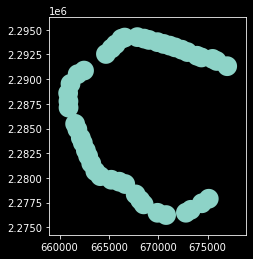

In [7]:
buffer.plot()

In [8]:
buffer = ox.project_gdf(buffer,to_crs='EPSG:4326')
tags = {'building': True}
gdf_building = gpd.GeoDataFrame()
#for b in range (len(buffer)):
for b in buffer.geometry:
    building = ox.geometries_from_polygon(b, tags)
    gdf_building = gdf_building.append(building)
    #print(buffer.iloc[b], gdf_building)

In [10]:
gdf_building.head(5)

,unique_id,osmid,element_type,geometry,nodes,building,addr:city,addr:street,name,office,...,fuel:biogas,self_service,internet_access:fee,rooms,fuel:octane_91,bus,ref,ele,addr:country,official_name
0,way/155165037,155165037,way,"POLYGON ((-103.40172 20.60263, -103.40165 20.6...","[4868672036, 1742199653, 1742199691, 174219968...",retail,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,way/155165039,155165039,way,"POLYGON ((-103.40539 20.60188, -103.40540 20.6...","[1742342181, 1742342173, 1742342171, 174234215...",industrial,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,way/155165045,155165045,way,"POLYGON ((-103.40351 20.60193, -103.40301 20.6...","[1742342186, 1742342180, 1742342147, 174234214...",yes,San Pedro Tlaquepaque,Independencia,INEGI,government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,way/155165046,155165046,way,"POLYGON ((-103.40609 20.60095, -103.40455 20.6...","[1742342112, 1742342104, 1742342066, 174234206...",industrial,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,way/155165061,155165061,way,"POLYGON ((-103.40431 20.60174, -103.40428 20.6...","[1742342167, 1742342183, 1742342182, 174234218...",yes,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

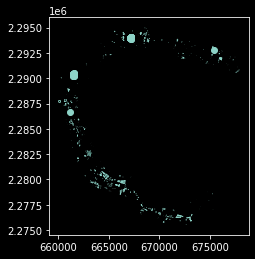

In [11]:
gdf_building = ox.project_gdf(gdf_building,to_crs='EPSG:32613')
gdf_building.plot()

In [18]:
buffer = ox.project_gdf(buffer,to_crs='EPSG:32613')
clip = gpd.clip(denue, buffer)
clip.head(5)

,id,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,ageb,manzana,telefono,correoelec,www,tipoUniEco,latitud,longitud,fecha_alta,geometry
10,7162426,TOTAL PUERTAS AUTOMATICAS,None,238290,Otras instalaciones y equipamiento en construc...,0 a 5 personas,CALLE,VOLCAN PARICUTIN,CALLE,VOLCAN DE BARU,...,4431,003,None,None,None,Fijo,20.643058,-103.432993,2019-11,POINT (663256.618 2283431.913)
15,8813205,TORRESDEL,GRUPO INMOBILIARIO Y EDIFICACIONES TORRESDEL ...,236111,Edificación de vivienda unifamiliar,6 a 10 personas,PERIFERICO,LATERAL AL PERIFERICO PONIENTE MANUEL GOMEZ MORIN,CALLE,RINCONADA PEÑARANDA,...,3147,001,None,RECEPCION@TORRESDEL.COM,None,Fijo,20.640424,-103.439781,2019-11,POINT (662552.103 2283133.499)
16,6146197,TRATAMIENTOS GEOTECNICOS,TRATAMIENTOS GEOTECNICOS SA DE CV,237312,"Construcción de carreteras, puentes y similares",0 a 5 personas,OTRO (ESPECIFIQUE),VOLCÁN DE BARÚ,AVENIDA,3,...,4431,029,None,AUTLAN61@HOTMAIL.COM,None,Fijo,20.646582,-103.432591,2010-07,POINT (663294.783 2283822.371)
17,7304547,TRANSTELCO,IPERMATRIX SA DE CV,238210,Instalaciones eléctricas en construcciones,6 a 10 personas,CALLE,22 DE ABRIL,CALLE,EMILIANO ZAPATA,...,2539,010,3322571880,IGM@TRANSTELCO.NET,WWW.TRANSTELCO.COM,Fijo,20.612181,-103.426567,2019-11,POINT (663959.251 2280020.276)
41,8281979,UPOL,None,238320,Trabajos de pintura y otros cubrimientos de pa...,0 a 5 personas,CALLE,CALLE DEL RELOJERO,CALLE,CALLE DEL SOL,...,1434,010,None,None,None,Fijo,20.581444,-103.342363,2019-11,POINT (672770.198 2276704.761)


In [19]:
gob = clip[clip['codigo_act'].str.startswith('931')]
gob.head(5)

,id,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,ageb,manzana,telefono,correoelec,www,tipoUniEco,latitud,longitud,fecha_alta,geometry
361126,1694541,ALMACÉN GENERAL DE GOBIERNO,ALMACÉN GENERAL DE GOBIERNO,931210,Administración pública en general,0 a 5 personas,CALLE,PUERTO GUAYMAS,CALLE,ANILLO PERIFERICO PONIENTE MANUEL GOMEZ MORIN,...,1723,017,3030954041,None,None,Fijo,20.641361,-103.441811,2014-12,POINT (662339.540 2283235.202)
361351,1848832,AYUNTAMIENTO ZAPOPAN,MANTENIMIENTO VEHICULAR,931210,Administración pública en general,11 a 30 personas,CALLE,ANTONIO MADRAZO,CALLE,NINGUNO,...,1032,017,3311993426,None,None,Fijo,20.733257,-103.361265,2014-12,POINT (670630.081 2293490.961)
361352,1697553,BASE 4 OPERATIVA BOMBEROS,MUNICIPIO DE ZAPOPAN,931410,Impartición de justicia y mantenimiento de la ...,31 a 50 personas,CALLE,NINGUNO,CALLE,LATERAL PERIFERICO (MANUEL GOMEZ MORIN),...,5251,001,None,None,None,Fijo,20.659281,-103.446801,2014-12,POINT (661800.552 2285213.961)
361940,8140570,BODEGA DEL ESTADO,DEPOSITO DE VEHICULOS NO 6 DEL GOBIERNO DEL ES...,931210,Administración pública en general,0 a 5 personas,CALLE,VOLCAN QUINCEO,PRIVADA,DEL SOL,...,1691,028,None,None,None,Fijo,20.643257,-103.443989,2019-11,POINT (662110.528 2283442.934)
361983,8606188,BODEGA GUBERNAMENTAL,SERVICIO DE ADMINISTRACION TRIBUTARIA SAT,931210,Administración pública en general,6 a 10 personas,PERIFERICO,ANILLO PERIFERICO NORTE MANUEL GOMEZ MORIN,CALLE,NINGUNO,...,5942,004,None,None,None,Fijo,20.701279,-103.450239,2019-11,POINT (661397.960 2289859.690)


<AxesSubplot:>

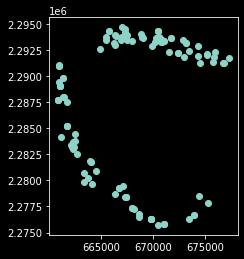

In [20]:
gob.plot()

In [21]:
gdf_building['area'] = gdf_building.geometry.area
gdf_building.head(5)

,unique_id,osmid,element_type,geometry,nodes,building,addr:city,addr:street,name,office,...,self_service,internet_access:fee,rooms,fuel:octane_91,bus,ref,ele,addr:country,official_name,area
0,way/155165037,155165037,way,"POLYGON ((666559.024 2278988.474, 666566.704 2...","[4868672036, 1742199653, 1742199691, 174219968...",retail,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37516.846177
1,way/155165039,155165039,way,"POLYGON ((666177.356 2278901.853, 666176.934 2...","[1742342181, 1742342173, 1742342171, 174234215...",industrial,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11080.361988
2,way/155165045,155165045,way,"POLYGON ((666373.468 2278909.256, 666425.255 2...","[1742342186, 1742342180, 1742342147, 174234214...",yes,San Pedro Tlaquepaque,Independencia,INEGI,government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2285.668246
3,way/155165046,155165046,way,"POLYGON ((666105.384 2278797.822, 666266.484 2...","[1742342112, 1742342104, 1742342066, 174234206...",industrial,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11151.399110
4,way/155165061,155165061,way,"POLYGON ((666290.375 2278887.052, 666293.065 2...","[1742342167, 1742342183, 1742342182, 174234218...",yes,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5041.507322


In [23]:
mean_area = gdf_building.area.mean()
mean_area

2122.941657146999

In [30]:
edificios_gob = gpd.sjoin(buffer,gob,how='left').groupby(['Name']).count().reset_index()
edificios_gob = edificios_gob[['Name','id']]

In [111]:
edificios_gob['area'] = edificios_gob['id']*mean_area
edificios_gob['kWh_year'] = edificios_gob['area']*consumed
edificios_gob['tonCO₂eq'] = edificios_gob['kWh_year']*emission
edificios_gob.head(5)

,Name,id,area,emisiones,kWh_year,tonCO₂eq
29,36. Magnolias,15,31844.124857,4.587465e+06,4.587465e+06,1900.265472
30,37. Tabachines,15,31844.124857,4.587465e+06,4.587465e+06,1900.265472
31,38. Cantera Morada,13,27598.241543,3.975803e+06,3.975803e+06,1646.896743
25,32. Valdepeñas,12,25475.299886,3.669972e+06,3.669972e+06,1520.212378
24,31. L3 Belenes,11,23352.358229,3.364141e+06,3.364141e+06,1393.528013


In [112]:
edificios_gob_ = edificios_gob.merge(gdf_est, right_on='Name', left_on = 'Name')
edificios_gob_ = gpd.GeoDataFrame(edificios_gob_, crs = gdf_est.crs)
edificios_gob_.sort_values(by='emisiones', ascending=False, inplace=True)
edificios_gob_.head(1)

,Name,id,area,emisiones,kWh_year,tonCO₂eq,x,y,geometry
0,36. Magnolias,15,31844.124857,4.587465e+06,4.587465e+06,1900.265472,-103.368075,20.735644,POINT (669918.196 2293748.022)


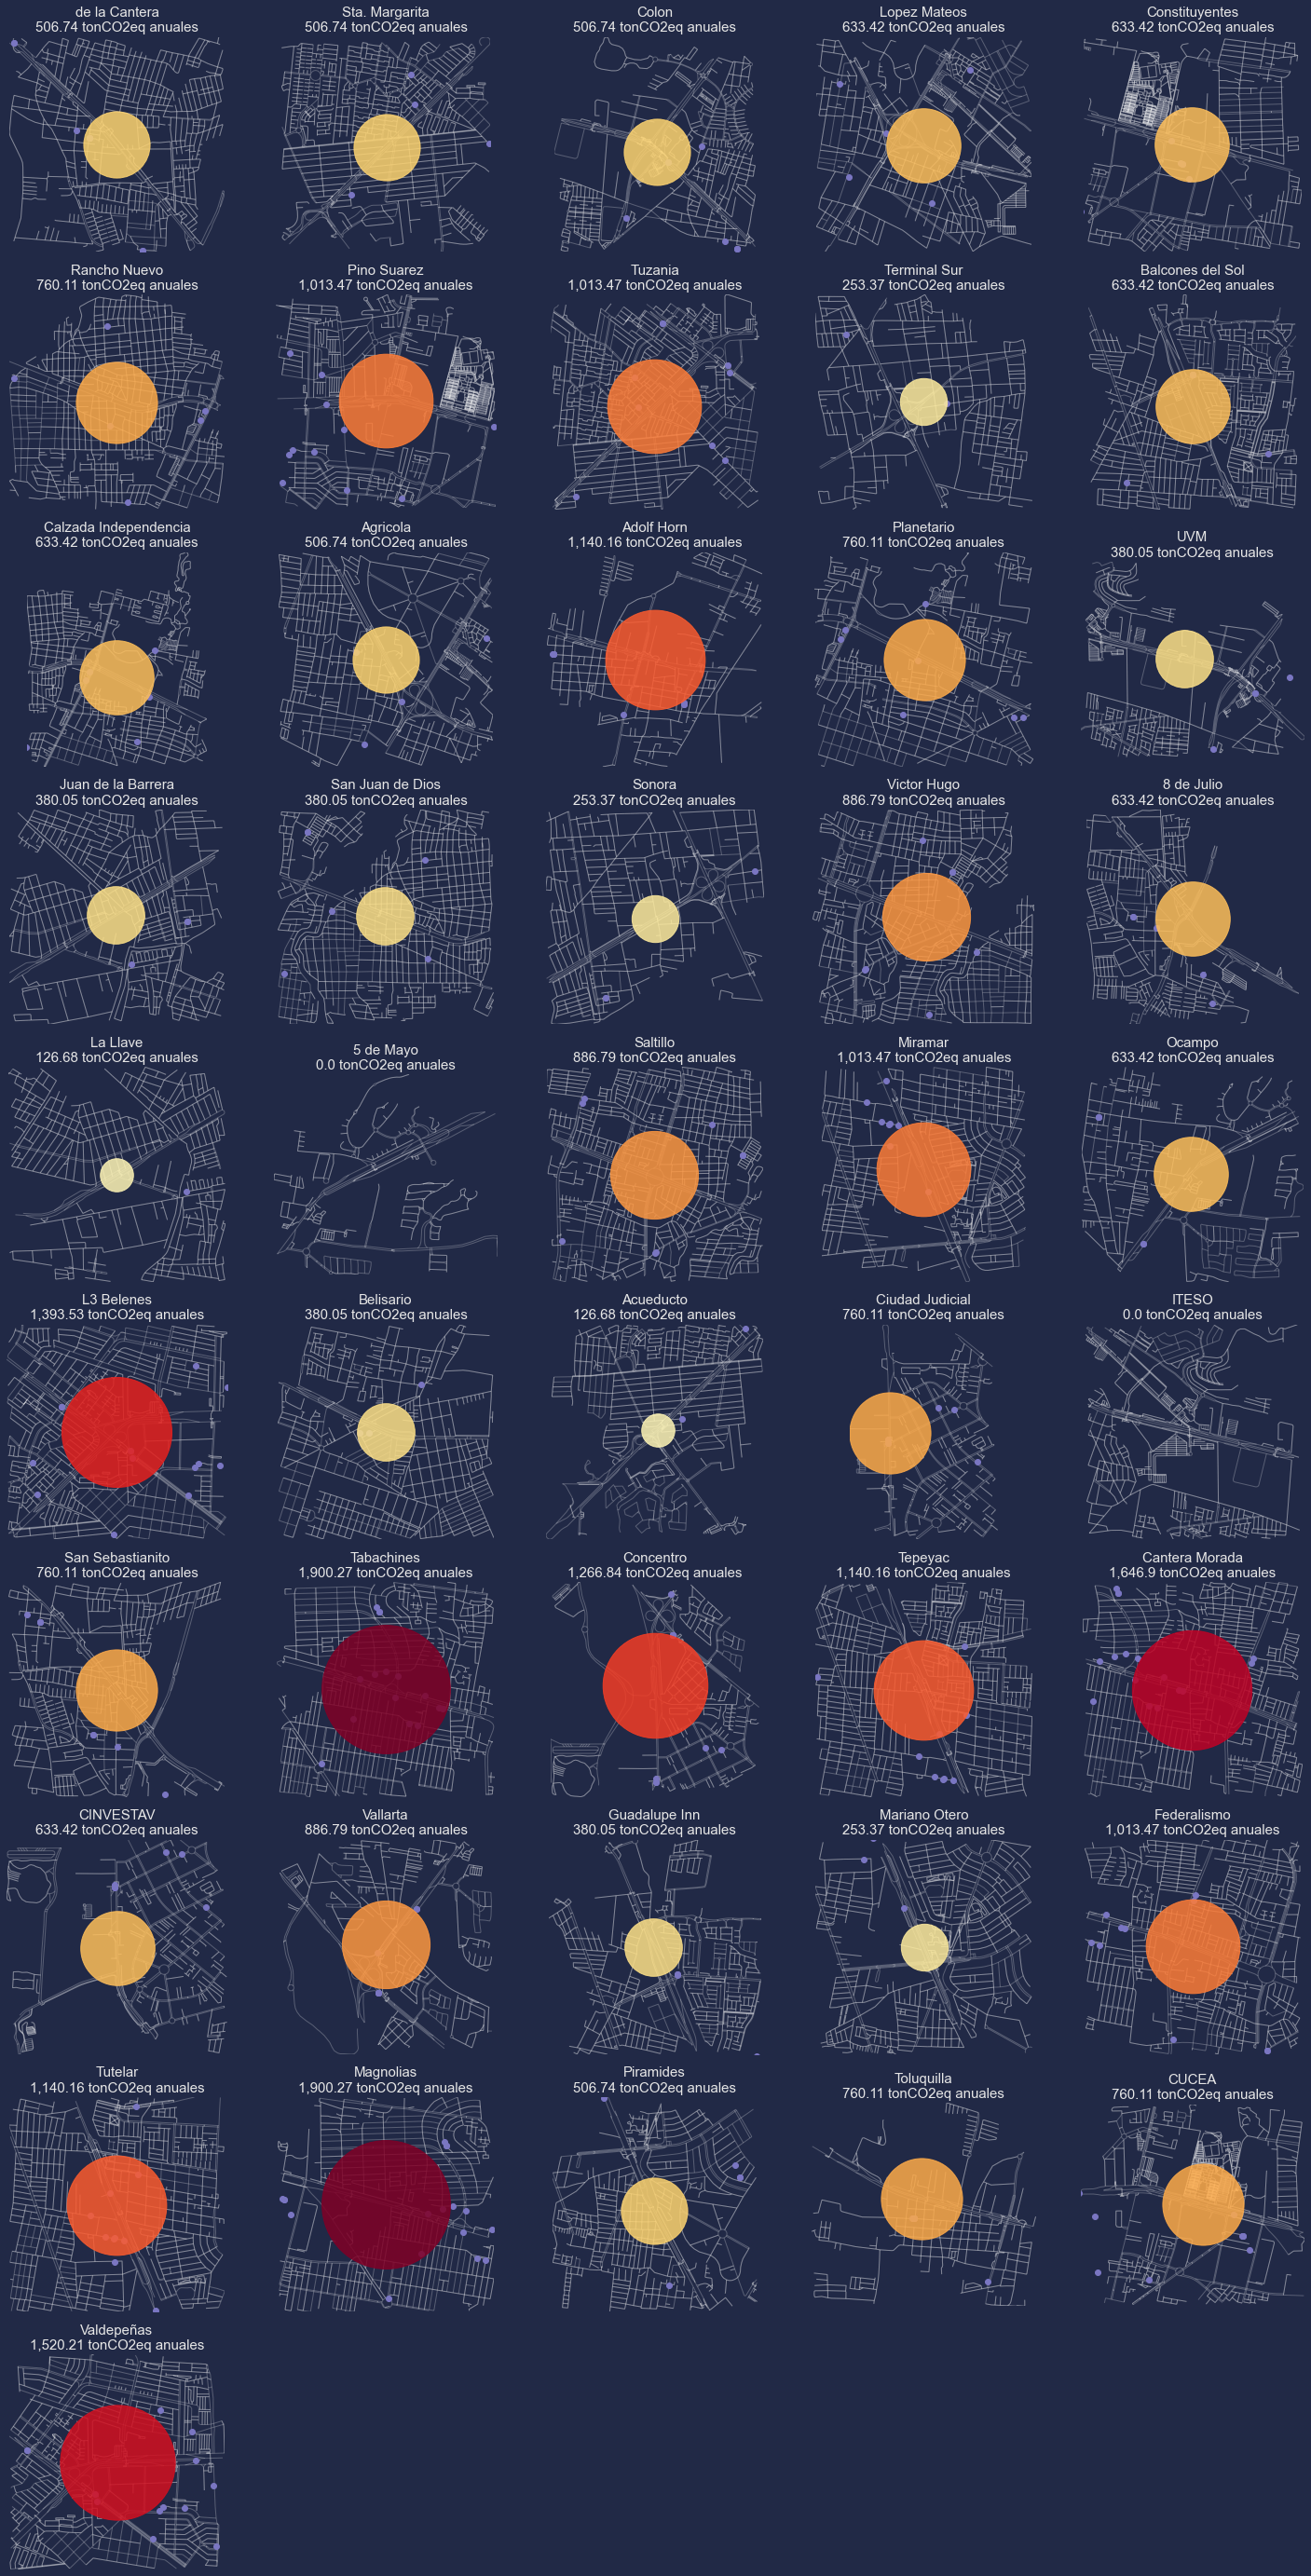

In [129]:
fig, axes = plt.subplots(10,5,figsize = (25,50))
for i, ax in zip(edificios_gob.index.tolist(), axes.flatten()):
    est = edificios_gob_.at[i,'Name']
    edges[edges['Estacion'] == est].plot(ax=ax, color='w', zorder=1, alpha=0.25, linewidth=1)
    edificios_gob_[edificios_gob_['Name'] == est].plot(ax=ax, column ='tonCO₂eq', cmap='YlOrRd', markersize=edificios_gob_[edificios_gob_['Name'] == est]['tonCO₂eq']*10, alpha=0.85, zorder=3, vmin=edificios_gob_['tonCO₂eq'].min(), vmax=edificios_gob_['tonCO₂eq'].max())
    gob.plot(ax=ax, color='#7A76C2', zorder=2)
    
    minx, miny, maxx, maxy = edges.loc[edges.Estacion==est].geometry.total_bounds
    ax.set_xlim(minx - .1, maxx + .1) # added/substracted value is to give some margin around total bounds
    ax.set_ylim(miny - .1, maxy + .1)
    
    ax.set_title('{}\n{:,} tonCO2eq anuales'.format(est.split(' ',maxsplit=1)[1], round(edificios_gob_[edificios_gob_['Name'] == est]['tonCO₂eq'].values[0],2)), fontsize=15)
    ax.axis('off')
for ax in axes.flatten()[46:]:
    ax.set_visible(False)
plt.savefig('../output/figures/emisiones_edificios/EmisionesEstaciones_Mapa.png',dpi=300)

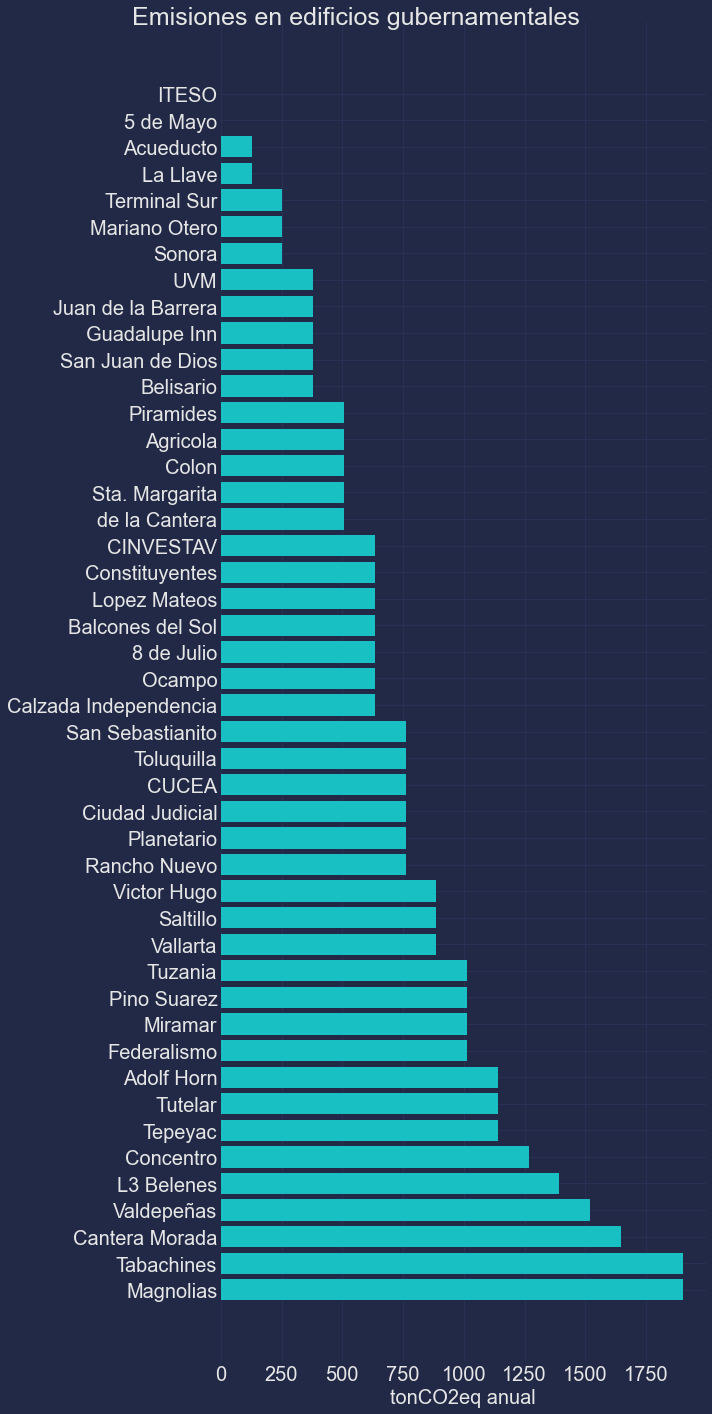

In [115]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
fig, ax = plt.subplots(1,1,figsize=(10,20))
ax.barh(edificios_gob_['Name'].apply(lambda x: x.split(' ',maxsplit=1)[1]), edificios_gob_['tonCO₂eq'])
ax.set_xlabel('tonCO2eq anual',fontsize=20)
ax.tick_params(labelsize=20)
fig.suptitle('Emisiones en edificios gubernamentales',fontsize=25)
fig.tight_layout()
plt.savefig('../output/figures/emisiones_edificios/EmisionesEstaciones.png',dpi=300)